# KAN: Kolmogorov–Arnold Networksを用いたmass model

2024年7月末頃、中国のグループによって、KANを用いた原子核のmass modelが提唱された: [arXiv:2407.20737v1](https://arxiv.org/abs/2407.20737)

実装をどうしたかや、細かなパラメータの記載が一切ないので完全再現は難しいと思われるが、
同様の手続きは簡単に実行でき、論文で示されているように高精度に内挿が出来そうなことは分かった。


KAN(2024年4月に提唱)はその性質からシンボリック回帰が行いやすく、
質量公式のrefinementや反応模型(光学ポテンシャルなど)とも親和性が高いと思われる。

以下のコードの実行には、PyTorchとpykanのインストールが必要

In [1]:
import torch
import torch.nn as nn
from kan import *
from efficient_kan import KAN as KAN_
import tqdm

## KANの式

KANの根幹は、「有界な領域上の連続な多変量関数は、有界領域上の単変数関数の合成で表現できる」というKolmogorov-Arnoldの表現定理である。

入力に対して予め決められた非線形関数(Affine変換→活性化関数)と学習可能な重みを持つ関数を構成するMLPと対照的に、
KANはノード間を繋ぐ関数を学習することで多変量関数を表現するという特徴がある。

簡単のため、$d$次元の入力$\mathbf{x}$を考えた単層のMLPとKANを比較する。

$$
\begin{align}
\text{MLP:} \quad f(\mathbf{x}) &= \sum^n_{i=1} a_i \sigma(\mathbf{w}_i \cdot \mathbf{x} + b_i)  \\
\text{KAN:} \quad f(\mathbf{x}) &= f(x_1, \cdots, x_d) = 
\sum^{2d+1}_{q=1} \Phi_q \left( \sum^d_{p=1} \phi_{q,p} (x_p) \right)
\end{align}
$$
ここで、$\phi_{p,q}: [0,1] \to \mathbb{R}$、$\Phi_q: \mathbb{R} \to \mathbb{R}$である。
後者は単層といいつつ、単変数関数の合成になっていることに注意。


* 原論文: [KAN: Kolmogorov-Arnold Networks, arXiv:2404.19756](https://arxiv.org/abs/2404.19756)

* 著者によるWebセミナー: https://www.youtube.com/watch?v=AUDHb-tnlB0

* 原論文を含む論文や実装については[Awesome KAN](https://github.com/mintisan/awesome-kan)というレポジトリが詳しい。

## データの準備

データとして、上記の論文と同様、Atomic Mass Evaluation (AME)の2020版を用いる。
AMEの野良パッケージもありそうだが、NuclearToolkit.jl内の関連する部分を流用する力技で対処する。

パッケージではAMEのデータがJulia言語の自作structの辞書になっている。これをPythonのDataFrameに変換&少し整形する。

In [2]:
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll
from matplotlib.colors import Normalize
import matplotlib.cm as cm

element = [ 'NA', 'H',  'He', 'Li', 'Be', 'B',  'C',  'N',  'O',  'F',  'Ne', 'Na', 'Mg', 'Al', 'Si', 'P',  'S',  'Cl', 'Ar', 'K',  
    'Ca', 'Sc', 'Ti', 'V',  'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y',  'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I',  'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W',  'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U',  'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og' ]

def get_amedata_in_myPkg():
    # BE, BEerr, BETF(False means estimatino by AME2020), Sn, Snerr, Qval, Qerr
    # → Nuc, Z, N, BE(MeV), BEerr(MeV), BETF, Sn(MeV), SnTF, Snerr(MeV), SnerrTF, Qval(MeV), QvalTF, Qerr(MeV), QerrTFとDataFrame化する
    url = "https://raw.githubusercontent.com/SotaYoshida/NuclearToolkit.jl/main/src/NuclData.jl/amedata.jl"
    with urllib.request.urlopen(url) as f:     
        lines = f.read().decode('cp932').split('\n')
    hit = 0
    array = [ ]
    for line in lines:
        if "ame2020data = Dict(" in line:
            hit = 1
            continue
        if hit == 0:
            continue
        if line.strip() == ")":
            break
        tmp = line.replace('"',"").split(",  ")
        key_nuc = tmp[0].split("=>")[0]
        keyZN = map(int, tmp[1].split("=>")[0].replace("[","").replace("]","").split(","))
        Z, N = keyZN
        A = Z + N 
        data = tmp[0].split("AMEdata(")[-1].replace(")","").split(",")
        data = data[0:4] + [False] + [data[4]] + [False] + [data[5]] + [False] + [data[6]] + [False]
        idxs = [0, 1, 2, 3, 5, 7, 9]
        for idx in idxs:
            tmp = data[idx]
            if idx == 2: # for rewriting BETF
                if data[idx] == "true":
                    data[idx] = True
                elif data[idx] == "false":
                    data[idx] = False
                else:
                    print("This should not happen:", tmp, "idx=",idx)
                continue
            if tmp == "" or tmp == "*":
                data[idx] = float('nan')
            elif "#" in tmp:
                data[idx] = float(data[idx].replace("#",""))
                data[idx] += 1
            else:
                data[idx] = float(data[idx])
            if idx in [0, 1, 3, 5, 7, 9]:
                data[idx] /= 10**3
                if idx in [0, 1]:
                    data[idx] *= A
        row = [key_nuc, Z, N] + data
        array += [ row ]
    df = pd.DataFrame(array, columns=["Nuc", "Z", "N", "BE(MeV)", "BEerr(MeV)", "BETF", "Sn(MeV)", "SnTF", "Snerr(MeV)", "SnerrTF", "Qval(MeV)", "QvalTF", "Qerr(MeV)", "QerrTF"])
    return df 

def add_more_info(df):
    #A, N-Z, A^(2/3), Z_EO, N_EO, Zm, Nm, Zshell, Nshellなどの情報を付加
    df["A"] = df["N"] + df["Z"]
    df["N-Z"] = df["N"]- df["Z"]    
    df["A^(2/3)"] = df["A"]**(2/3)
    df["Z_EO"] = df["Z"] % 2
    df["N_EO"] = df["N"] % 2
    ref_magic = np.array([0, 8, 20, 28, 50, 82, 126, 184])
    Zm = [ ]; Nm = [ ]
    ref_shell = np.array([0, 29,  51, 83, 127])
    Zsh = [ ]; Nsh = [ ]
    for idx in range(df.shape[0]):
        Z = df.loc[idx,"Z"]
        N = df.loc[idx,"N"]
        Zsub = Z - ref_magic
        Nsub = N - ref_magic
        Zres = np.min( Zsub[ Zsub >= 0 ] )
        Nres = np.min( Nsub[ Nsub >= 0 ] )
        if not(Z-Zres in ref_magic) or not(N-Nres in ref_magic):
            print(Z, N, Zres, Nres, "Zsub", Zsub)
            raise ValueError("something wrong for Zm/Nm")
        Zm += [Zres]
        Nm += [Nres]
        tZs = tNs = 4
        for ishell in range(len(ref_shell)):
            if Z >= ref_shell[ishell]:
                tZs = ishell
            if N >= ref_shell[ishell]:
                tNs = ishell
        Zsh += [tZs]
        Nsh += [tNs]
    df["Zm"] = Zm; df["Nm"] = Nm
    df["Zshell"] = Zsh; df["Nshell"] = Nsh
    
df = get_amedata_in_myPkg()
add_more_info(df)
display(df)

,Nuc,Z,N,BE(MeV),BEerr(MeV),BETF,Sn(MeV),SnTF,Snerr(MeV),SnerrTF,...,QerrTF,A,N-Z,A^(2/3),Z_EO,N_EO,Zm,Nm,Zshell,Nshell
0,n1,0,1,0.000000,0.000000e+00,True,0.000000,False,0.000000e+00,False,...,False,1,1,1.000000,0,1,0,1,0,0
1,H1,1,0,0.000000,0.000000e+00,True,NaN,False,NaN,False,...,False,1,-1,1.000000,1,0,1,0,0,0
2,H2,1,1,2.224566,4.000000e-07,True,2.224566,False,4.000000e-07,False,...,False,2,0,1.587401,1,1,1,1,0,0
3,H3,1,2,8.481796,9.000000e-07,True,6.257230,False,4.000000e-07,False,...,False,3,1,2.080084,1,0,1,2,0,0
4,He3,2,1,7.718041,4.500000e-07,True,NaN,False,NaN,False,...,False,3,-1,2.080084,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,Ts293,117,176,2078.835000,8.790000e-01,False,7.265000,False,1.027000e+00,False,...,False,293,59,44.114201,1,0,35,50,3,4
3554,Og293,118,175,2073.854000,5.860000e-01,False,NaN,False,NaN,False,...,False,293,57,44.114201,0,1,36,49,3,4
3555,Ts294,117,177,2085.048000,5.880000e-01,False,6.104000,False,9.790000e-01,False,...,False,294,60,44.214517,1,1,35,51,3,4
3556,Og294,118,176,2081.226000,5.880000e-01,False,7.554000,False,9.000000e-01,False,...,False,294,58,44.214517,0,0,36,50,3,4


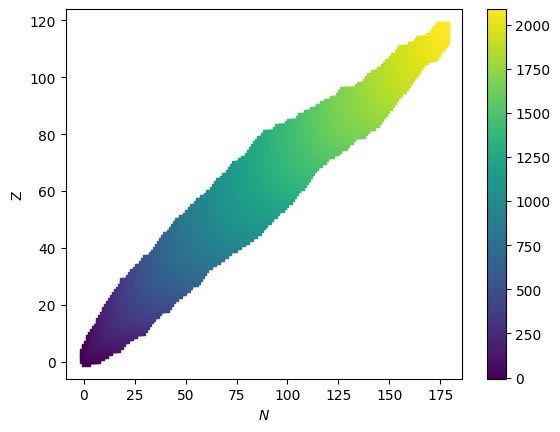

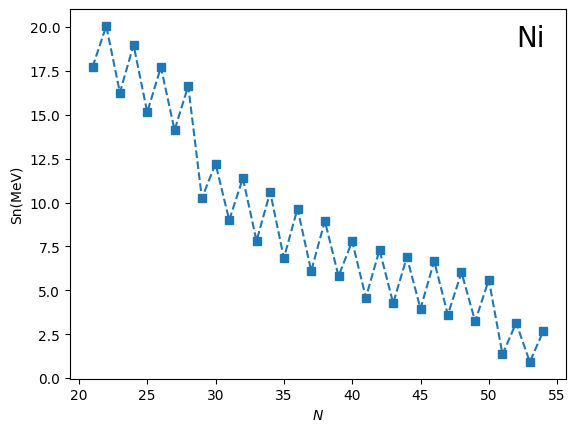

In [3]:
def plot_chart(df, item):
    z = df[item].values
    x = df["N"].values
    y = df["Z"].values
    fig = plt.figure()
    ax = plt.subplot(1,1,1); ax.set_xlabel("$N$"); ax.set_ylabel("Z")
    im = ax.scatter(x, y, marker="s", c=z)
    fig.colorbar(im)
    plt.show()
    plt.close()

def plot_item_for_isotopes(df, item, Z):
    subdf = df[ df["Z"] == Z ]
    y = subdf[item].values
    x = subdf["N"].values
    fig = plt.figure()
    ax = plt.subplot(1,1,1); ax.set_xlabel("$N$"); ax.set_ylabel(item)
    ax.plot(x, y, marker="s", ls="dashed")
    ax.text(0.9,0.9,element[Z], transform=ax.transAxes,fontsize=20)
    plt.show()
    plt.close()

item = "BE(MeV)"
plot_chart(df, item)

item = "Sn(MeV)"
plot_item_for_isotopes(df, item, 28)

論文では、以下の表のように4つのモデルと特徴量を考えている:

| Model | Features |
| ---- | ---- |
| KAN-2| $N, Z$|
| KAN-4| $N, Z, A, N-Z$|
| KAN-9| $N, Z, A, N-Z, A^{2/3}, Z_\mathrm{EO}, N_\mathrm{EO}, Z_\mathrm{m}, N_\mathrm{m}$|
| KAN-11|$N, Z,A, N-Z, A^{2/3}, Z_\mathrm{EO}, N_\mathrm{EO}, Z_\mathrm{m}, N_\mathrm{m}, Z_\mathrm{shell}, N_\mathrm{shell}$|



## Loss function


論文で用いられている誤差関数は、L1正則化と交差エントロピーを有した形:

$$
\mathcal{L} = \frac{ (\mathrm{BE}_\mathrm{pred}-\mathrm{BE}_\mathrm{exp})^2}{N_p} + \lambda \left(  \mu_1 \sum^{L-1}_{l=0} ||\Phi_l||_1 + \mu_2 \sum^{L-1}_{l=0} S(\Phi_l) \right)
$$

$N_p$は入力(prediction data)の数、$L$はlayerの数、$l$は$l$番目のレイヤーを意味する。

L1 norm:

$$
||\phi||_1 \equiv \frac{1}{N_p}\sum^{N_p}_{s=1} | \phi(x^{(s)}) | \\
||\Phi||_1 \equiv \sum^{n_\mathrm{in}}_{i=1} \sum^{n_\mathrm{out}}_{j=1} || \phi_{i,j} ||_1
$$

cross entropy:

$$
S(\Phi) \equiv - \sum^{n_\mathrm{in}}_{i=1} \sum^{n_\mathrm{out}}_{j=1} \frac{||\phi_{i,j}||_1}{||\Phi||_1} \log \frac{||\phi_{i,j}||_1}{||\Phi||_1} 
$$

論文でどうしているかは書かれていないが、KANの論文には通常(特に理由がなければという意味だと思うが)$\mu_1 =\mu_2$にすると書いてある。
また、$\lambda$についても$10^{-2}$とか$10^{-3}$と書かれてある。

## データセットの作成

上で作ったDataFrameから、データセットを作成する。

モデルごとに特徴量が異なるので、それに合わせてデータセットを作成する関数を作っておく。

In [4]:
features = {2: ["Z", "N"], 
            4: ["Z", "N", "A", "N-Z"],
            9: ["Z", "N", "A", "N-Z", "A^(2/3)", "Z_EO", "N_EO", "Zm", "Nm"],
            11: ["Z", "N", "A", "N-Z", "A^(2/3)", "Z_EO", "N_EO", "Zm", "Nm", "Zshell", "Nshell"]}

def extract_data_for_model(df, model_feature, item="BE(MeV)", Zmin=8, Nmin=8, Zmax=500, Nmax=500):    
    subdf = df[ (df["Z"] >= Zmin) & (df["Z"] <= Zmax ) & (df["N"] >= Nmin) & (df["N"] <= Nmax) ][features[model_feature]+[item]]
    return subdf

model_feature = 11
subdata = extract_data_for_model(df, model_feature, item="BE(MeV)") # to be data of 3456 nuclei
subdata

,Z,N,A,N-Z,A^(2/3),Z_EO,N_EO,Zm,Nm,Zshell,Nshell,BE(MeV)
75,8,8,16,0,6.349604,0,0,0,0,0,0,127.619315
81,8,9,17,1,6.611489,0,1,0,1,0,0,131.762395
82,9,8,17,-1,6.611489,1,0,1,0,0,0,128.219583
88,8,10,18,2,6.868285,0,0,0,2,0,0,139.807766
89,9,9,18,0,6.868285,1,1,1,1,0,0,137.369489
...,...,...,...,...,...,...,...,...,...,...,...,...
3553,117,176,293,59,44.114201,1,0,35,50,3,4,2078.835000
3554,118,175,293,57,44.114201,0,1,36,49,3,4,2073.854000
3555,117,177,294,60,44.214517,1,1,35,51,3,4,2085.048000
3556,118,176,294,58,44.214517,0,0,36,50,3,4,2081.226000


論文では、3つのデータセットに分けてcross validationを行っているが、ここでは1つのデータセットにまとめてしまって、70%を訓練データ、残りをテストデータとして使うことにする。

In [5]:
def create_dataset_AME(subdata, rate_train=0.75, verbose=True, normalize_input=True, normalize_label=True, device='cpu', seed=0):
    '''
    create dataset
    
    Args:
    -----
        rate_train: float
            the ratio of training data. Default: 0.7.

        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    NumD = subdata.shape[0]
    idxs = np.random.permutation(NumD)
    train_idxs = idxs[0:int(NumD*rate_train)]
    test_idxs = idxs[int(NumD*rate_train):]
    
    # X: features
    train_input = torch.tensor(subdata.iloc[train_idxs,0:-1].values, dtype=torch.float32)
    test_input = torch.tensor(subdata.iloc[test_idxs,0:-1].values, dtype=torch.float32)

    # Y: target
    train_label = torch.tensor(subdata.iloc[train_idxs,[-1]].values, dtype=torch.float32) 
    test_label = torch.tensor(subdata.iloc[test_idxs,[-1]].values, dtype=torch.float32)
                
    def normalize(data, mean_in=None, std_in=None):
        if mean_in is not None and std_in is not None:
            mean = mean_in
            std = std_in
        else:
            mean = torch.mean(data, dim=0, keepdim=True)
            std = torch.std(data, dim=0, keepdim=True)
        return (data-mean)/std, mean, std
        
    if normalize_input == True:
        train_input, mean_input, std_input = normalize(train_input)
        test_input, dum1, dum2 = normalize(test_input,mean_in=mean_input,std_in=std_input)
        
    if normalize_label == True:
        train_label, mean_label, std_label = normalize(train_label)
        test_label, dum1, dum2 = normalize(test_label,mean_in=mean_label,std_in=std_label)
    
    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)
    
    return dataset, mean_input, std_input, mean_label, std_label

def inverse_normalize(data, mean, std):
    return data*std + mean

dataset, mean_input, std_input, mean_label, std_label = create_dataset_AME(subdata)

## モデルの構築&学習

KANの構築や学習は[pykan](https://github.com/KindXiaoming/pykan)に倣う。

KAN論文の著者によるもので、これ以降にも様々なモデルが提案されている。

オリジナルの実装では、KANレイヤーの活性化関数としてB-splineを用いている。
ネットワークの構造, grid数, B-splineの次数を与えてモデルを構築できる。簡単。

In [7]:
dataset

{'train_input': tensor([[ 1.0905,  1.4676,  1.3315,  ...,  0.4004,  1.3325,  1.3451],
         [ 0.7209,  0.7631,  0.7526,  ...,  1.5809,  0.3291,  0.5362],
         [ 1.1644,  0.9275,  1.0276,  ...,  2.1712,  1.3325,  0.5362],
         ...,
         [ 0.2774,  0.4343,  0.3763,  ...,  0.4004,  0.3291,  0.5362],
         [-0.1661,  0.2934,  0.1158,  ..., -0.1056,  0.3291,  0.5362],
         [-0.9422, -0.8104, -0.8684,  ..., -1.3705, -0.6744, -1.0817]]),
 'test_input': tensor([[ 0.5731,  0.8101,  0.7236,  ...,  1.7496,  0.3291,  0.5362],
         [ 1.3123,  1.1388,  1.2157,  ..., -0.7802,  1.3325,  1.3451],
         [ 0.6840,  0.4813,  0.5644,  ...,  0.5690,  0.3291,  0.5362],
         ...,
         [-0.1291, -0.0589, -0.0868,  ..., -1.3705,  0.3291, -0.2728],
         [ 0.9797,  0.6222,  0.7671,  ...,  1.0750,  1.3325,  0.5362],
         [ 1.0166,  0.8335,  0.9118,  ...,  1.8339,  1.3325,  0.5362]]),
 'train_label': tensor([[ 1.2815],
         [ 0.8191],
         [ 1.0080],
         ...

In [6]:
model_feature = 11 # 2/4/9/11
item = "BE(MeV)"
subdata = extract_data_for_model(df, model_feature, item=item) 
dataset, mean_input, std_input, mean_label, std_label = create_dataset_AME(subdata)

itnum = 300
using_effkan = False

if not(using_effkan): #original
    model = KAN(width=[model_feature, 10, 1], grid=30, k=3) 
    res = model.fit(dataset, opt="LBFGS", steps=itnum)
else: #efficient-kan
    kan = KAN_([model_feature, 5, 1], grid_size=30, spline_order=3) #efficient_kan
    optimizer = torch.optim.LBFGS(kan.parameters(), lr=1)
    optimizer.zero_grad()
    loss_log = [ ]
    lam = 1.e-5
    with tqdm.tqdm(range(itnum)) as pbar:
        for i in pbar:
            loss, reg_loss, test_loss, test_reg_loss = None, None, None, None
            def closure():
                optimizer.zero_grad()
                x = dataset['train_input']
                y = dataset['train_label']
                xtest = dataset['test_input']
                ytest = dataset['test_label']
                yhat = kan(x)
                yhat_test = kan(xtest)
                global loss, reg_loss, test_loss, test_reg_loss

                loss = nn.functional.mse_loss(yhat,y)
                reg_loss = kan.regularization_loss(1, 0)
                (loss + lam * reg_loss).backward()

                test_loss = nn.functional.mse_loss(yhat_test,ytest) 
                test_reg_loss = lam * reg_loss            
                return loss + reg_loss
            optimizer.step(closure)
            pbar.set_postfix(mse_loss=loss.item(), reg_loss=reg_loss.item())
            loss_log += [ [ loss.item(), reg_loss.item(), test_loss.item(), test_reg_loss.item()] ]
    model = kan
    loss_log = np.array(loss_log).T

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.93e-03 | test_loss: 5.41e-03 | reg: 0.00e+00 | :   6%| | 17/300 [00:18<05:15,  1.11s


KeyboardInterrupt: 

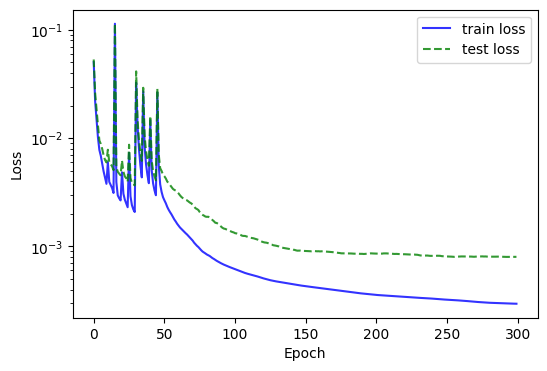

In [ ]:
# Lossのプロット
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
if using_effkan:
    ax.plot(loss_log[0], label="train loss", color="blue",alpha=0.8)
    ax.plot(loss_log[2], label="test loss", color="green",ls="dashed",alpha=0.8)
else:
    ax.plot(res['train_loss'], label="train loss", color="blue",alpha=0.8)
    ax.plot(res['test_loss'], label="test loss", color="green",ls="dashed",alpha=0.8)
ax.set_xlabel("Epoch");ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
plt.savefig("loss_"+str(model_feature)+".pdf")
plt.show()
plt.close()

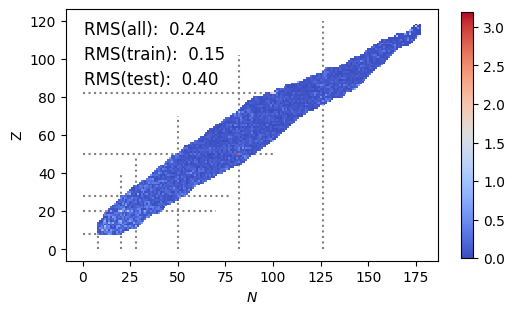

In [ ]:
# Z,NとBE全てまとめてしまう
xy_train = inverse_normalize(dataset['train_input'], mean_input, std_input)
xy_test  = inverse_normalize(dataset['test_input'], mean_input, std_input)
E_train = inverse_normalize(dataset['train_label'], mean_label, std_label)
E_test = inverse_normalize(dataset['test_label'], mean_label, std_label)
E_train_pred = inverse_normalize(model(dataset['train_input']), mean_label, std_label)
E_test_pred = inverse_normalize(model(dataset['test_input']), mean_label, std_label)
z_train = np.abs( list((E_train_pred-E_train).detach().numpy()) + list((E_test_pred-E_test).detach().numpy()) )

x = np.array( list(xy_train.detach().numpy()[:,1]) + list(xy_test.detach().numpy()[:,1]) )
y = np.array( list(xy_train.detach().numpy()[:,0]) + list(xy_test.detach().numpy()[:,0]) )

rms_train = (E_train - E_train_pred).pow(2).mean().sqrt().item()
rms_test = (E_test-E_test_pred).pow(2).mean().sqrt().item()
rms = np.sqrt( np.dot(z_train[:,-1], z_train[:,-1])/len(z_train) )

# plot
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1, aspect="equal"); ax.set_xlabel("$N$"); ax.set_ylabel("Z")
wid = hei = 1.0

cmap = plt.get_cmap("coolwarm")
norm = Normalize(vmin=np.min(z_train), vmax=np.max(z_train)/2)
colored_data = cmap(norm(z_train))

for idx in range(x.shape[0]):
    tx = x[idx] - wid/2
    ty = y[idx] - hei/2
    sq = patches.Rectangle((tx, ty), wid, hei, color = colored_data[idx][0][:3], fill=True, lw=0)
    ax.add_patch(sq)
ax.plot( [0,8], [8,8], color="gray", ls="dotted",zorder=100)
im = ax.plot( [8,8], [0,8], color="gray", ls="dotted",zorder=100)
for magic in [20, 28, 50, 82, 126]:
    if magic == 126:
        ax.plot( [magic,magic], [0,120], color="gray", ls="dotted",zorder=-1)
    else:
        ax.plot( [0,magic+50], [magic,magic], color="gray", ls="dotted",zorder=-1)
        ax.plot( [magic,magic], [0,magic+20], color="gray", ls="dotted",zorder=-1)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.8)
ax.text(0.05, 0.8, "RMS(train):"+str("%6.2f" % rms_train), transform=ax.transAxes,fontsize=12)
ax.text(0.05, 0.7, "RMS(test):"+str("%6.2f" % rms_test), transform=ax.transAxes,fontsize=12)
ax.text(0.05, 0.9, "RMS(all):"+str("%6.2f" % rms), transform=ax.transAxes,fontsize=12)
plt.savefig("AME2020_"+str(model_feature)+".pdf")
plt.show()
plt.close()



node=5, grid=10, k=3の場合の実行結果例を示しておく

| Model | RMS_train (MeV) | RMS_test (MeV) | 
| ---- | ---- | ---- |
| KAN-2| 0.81 | 0.98 |
| KAN-4| 0.76 | 1.10 |
| KAN-9| 0.15 | 0.79 |
| KAN-11| 0.19| 0.45 |

特徴量の数に比例して、精度が向上している、という単純な振る舞いではない(もうすこし詳しく原因は調べないといけない)が、KAN-11の精度はかなり良い。

- 魔法数の付近で悪くなる
- shellの効果を含めると(KAN-9,Kan-11)良くなる

という一般的な傾向も見えている。

ガウス過程/サポートベクターマシンを用いた方法[E. Yüksel, Phys. Rev. C 109, 064322 (2024)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.109.064322)と比べても遜色ない。

最後に、得られた結果をDataFrameにまとめて、$S_n$を描いてみる。

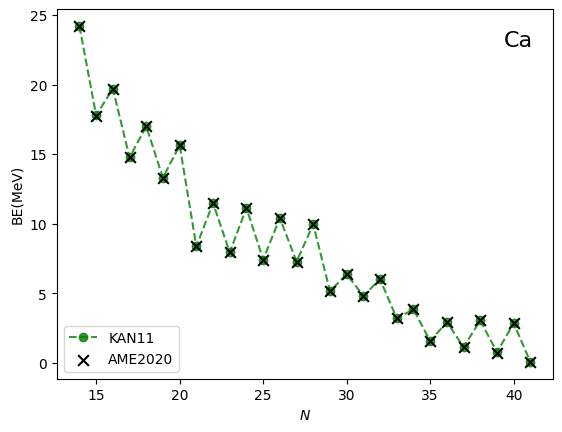

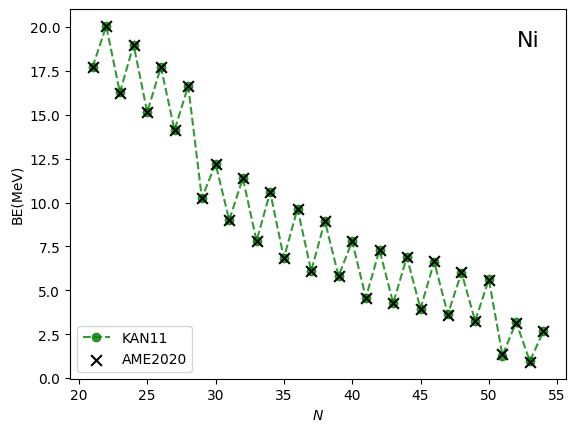

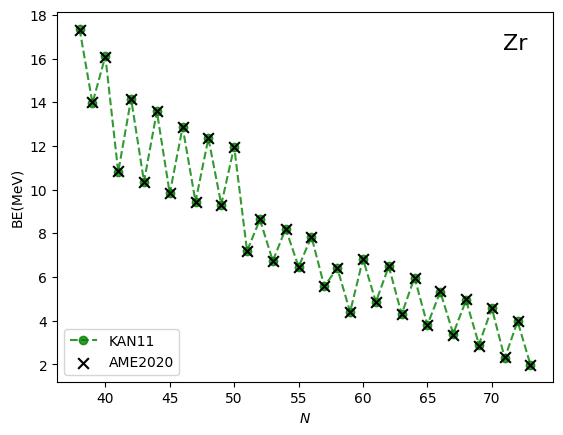

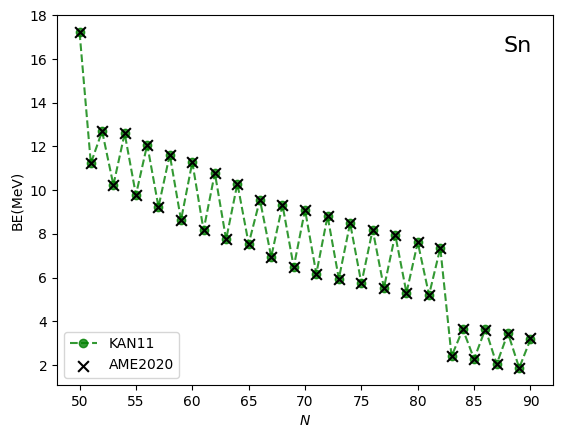

In [ ]:
df_pred = pd.DataFrame( np.array([x,y]).T, columns=["N","Z"])
df_pred["N-Z"] = df_pred["N"] - df_pred["Z"]
df_pred["A"] = df_pred["N"] + df_pred["Z"]
df_pred["A^(2/3)"] = df_pred["A"]**(2/3)
df_pred["BE(MeV)"] = np.array( list(E_train.detach().numpy()) + list(E_test.detach().numpy()) )

for target_Z in [20, 28, 40, 50]:
    # AME2020
    subdf = df[ df["Z"] == target_Z ]; y_data = subdf["Sn(MeV)"].values; x_data = subdf["N"].values

    # prediction
    subdf_pred = df_pred[ np.abs(df_pred["Z"] - target_Z) < 1.e-3 ]

    x_pred = sorted(subdf_pred["N"].values)
    y_pred = [ ]
    for xtmp in sorted(x_pred):
        BE = subdf_pred[np.abs( subdf_pred["N"] - xtmp ) < 1.e-3 ]["BE(MeV)"].values[0]
        try:
            BEprev = subdf_pred[ np.abs(subdf_pred["N"] - (xtmp-1)) < 1.e-3 ]["BE(MeV)"].values[0]
            Sn = BE - BEprev
        except:
            Sn = None
        y_pred += [Sn]
        #print(xtmp, BE, Sn)

    fig = plt.figure()
    ax = plt.subplot(1,1,1); ax.set_xlabel("$N$"); ax.set_ylabel(item)
    ax.plot(x_pred, y_pred, marker="o", ls="dashed", color="green",alpha=0.8,label="KAN"+str(model_feature))
    ax.scatter(x_data, y_data, marker="x", s=60, color="k", label="AME2020",zorder=100)
    ax.text(0.9, 0.9, element[target_Z], transform=ax.transAxes,fontsize=16)
    ax.legend()
    plt.show()
    plt.close()


## シンボリック回帰

KANは初等関数の組み合わせで関数を表現するシンボリック回帰が可能で、それが"解釈性が高い"という謳い文句に繋がっている。

特徴量が$(Z,N,A,N-Z)$の4つだけのモデルを作り、訓練したモデルを、シンボリック回帰で表現してみる。

In [ ]:
model_feature = 4
subdata = extract_data_for_model(df, model_feature, item="BE(MeV)") 
dataset, mean_input, std_input, mean_label, std_label = create_dataset_AME(subdata)

model = KAN(width=[model_feature, 5, 1], grid=30, k=3)
model.fit(dataset, opt="LBFGS", steps=200);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-03 | test_loss: 2.09e-03 | reg: 2.01e+01 | : 100%|█| 200/200 [01:46<00:00,  1.87

saving model version 0.1


In [ ]:
mode = "auto" # "manual"

if mode == "manual": #関数形を指定することもできる
    # 以下は例
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
    #...
elif mode == "auto":
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9971113801002502, c=2
fixing (0,0,1) with sin, r2=0.9981468915939331, c=2
fixing (0,0,2) with x, r2=0.884239137172699, c=1
fixing (0,0,3) with x^2, r2=0.9956830143928528, c=2
fixing (0,0,4) with x, r2=0.8157811164855957, c=1
fixing (0,1,0) with x, r2=0.8271763324737549, c=1
fixing (0,1,1) with sin, r2=0.9993276596069336, c=2
fixing (0,1,2) with x, r2=0.7996068000793457, c=1
fixing (0,1,3) with x, r2=0.3678431510925293, c=1
fixing (0,1,4) with sin, r2=0.9952587485313416, c=2
fixing (0,2,0) with sin, r2=0.9946975708007812, c=2
fixing (0,2,1) with x, r2=0.8646169304847717, c=1
fixing (0,2,2) with x, r2=0.8563868999481201, c=1
fixing (0,2,3) with x^2, r2=0.9962589144706726, c=2
fixing (0,2,4) with sin, r2=0.9959537982940674, c=2
fixing (0,3,0) with x, r2=0.9138343334197998, c=1
fixing (0,3,1) with sin, r2=0.9986011981964111, c=2
fixing (0,3,2) with x, r2=0.42480528354644775, c=1
fixing (0,3,3) with sin, r2=0.9871638417243958, c=2
fixing (0,3,4) with x^2, r2=0.

In [ ]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0],4)

0.2623*x_1 - 0.096*x_2 + 0.1*x_3 + 0.0255*x_4 + 0.1014*(-0.771*x_1 - 1)**2 + 0.1616*(-0.6233*x_4 - 1)**2 - 1.4313*exp(0.0321*x_2 - 0.8231*(-0.7552*x_1 - 1)**2 - 0.4367*(-0.7441*x_3 - 1)**2 - 0.3137*sin(1.1719*x_4 + 2.3981)) + 1.2325*sin(0.1832*x_1 - 7.6203) + 2.4272*sin(0.2322*x_2 + 5.02799987792969) + 0.2274*sin(0.4668*x_2 - 7.324) - 0.5038*sin(0.4902*x_3 - 7.3243) - 0.8311*sin(0.597*x_3 - 1.0053) + 0.5557*sin(0.273*x_4 - 7.5106) + 3.2037

In [ ]:
E_train_pred = inverse_normalize(model(dataset['train_input']), mean_label, std_label)
E_test_pred = inverse_normalize(model(dataset['test_input']), mean_label, std_label)
z_train = np.abs( list((E_train_pred-E_train).detach().numpy()) + list((E_test_pred-E_test).detach().numpy()) )
rms = np.sqrt( np.dot(z_train[:,-1], z_train[:,-1])/len(z_train) )

print("RMS(MeV)=", str("%6.3f" % rms))

RMS(MeV)= 68.480


精度はかなり悪くなってしまう(特徴量を増やしても実は同じ)

pykanには残念ながら現時点では、[分数次の関数を用いた回帰はないよう](https://github.com/KindXiaoming/pykan/issues/19#issuecomment-2089587653)なので、その辺りは自前で実装するか、
サポートしているサードパーティのライブラリを探す必要がある。
(中国グループはプレプリントの中で質量公式っぽい表式に回帰も行っているようだが、どう実装したかなど、詳細は不明).

色々と考えるべきことは多そうだが質量公式など、初等関数での表現が欲しい状況と馴染むかもしれない。